In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.55 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

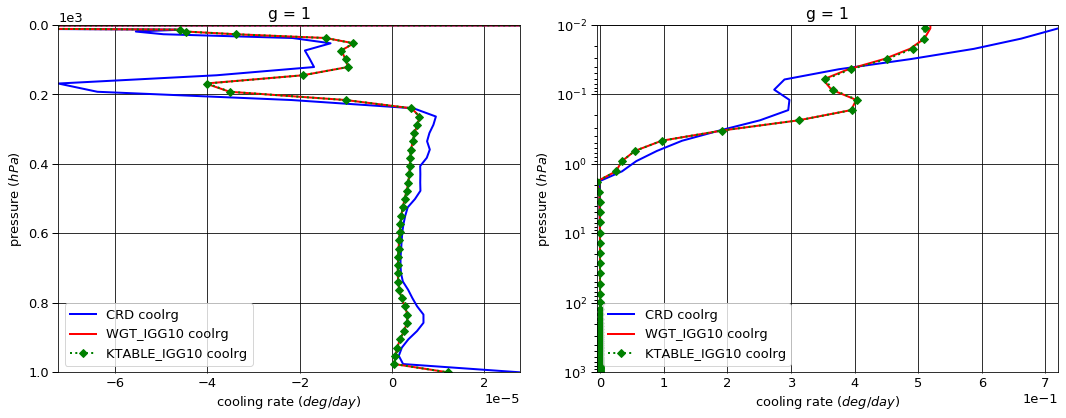

# Figure: cooling rate g-group 2

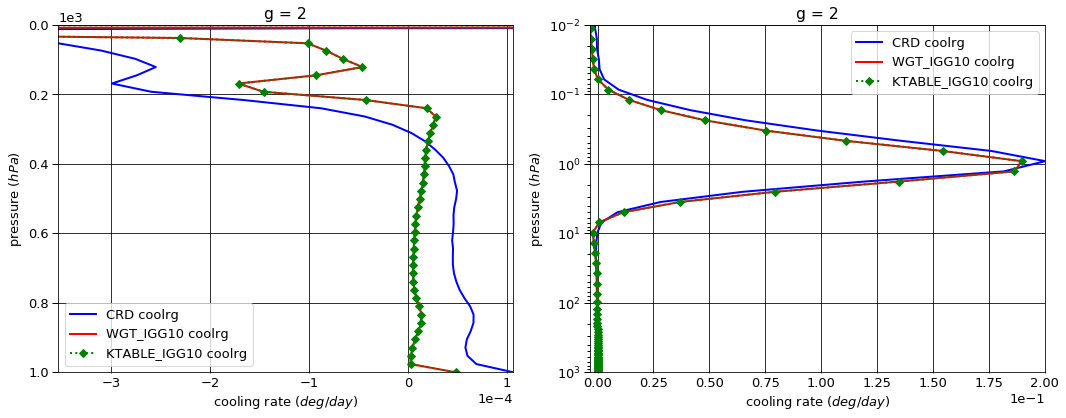

# Figure: cooling rate g-group 3

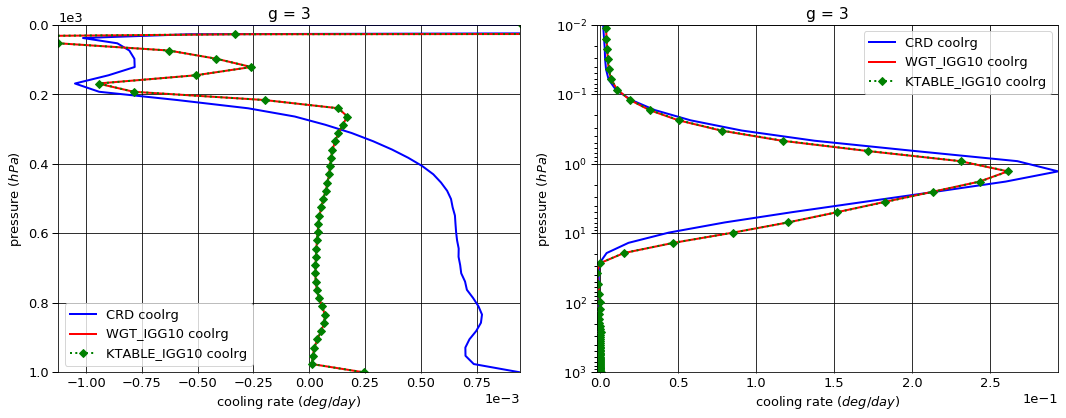

# Figure: cooling rate g-group 4

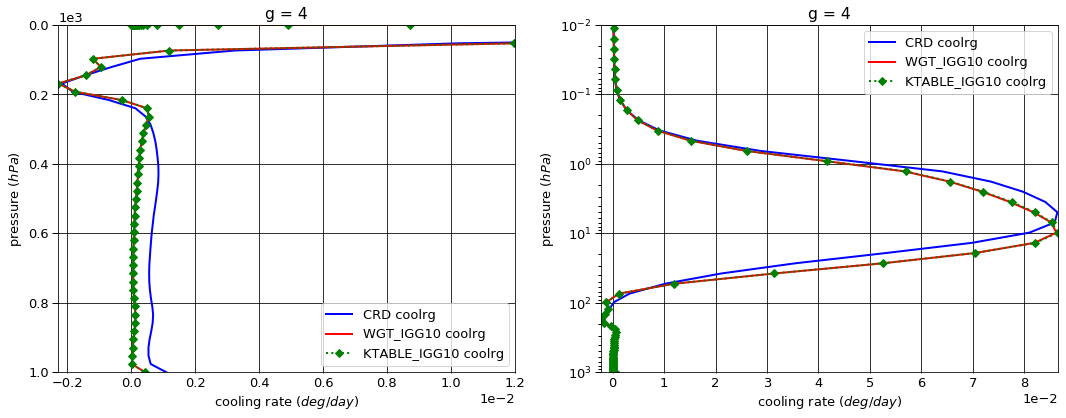

# Figure: cooling rate g-group 5

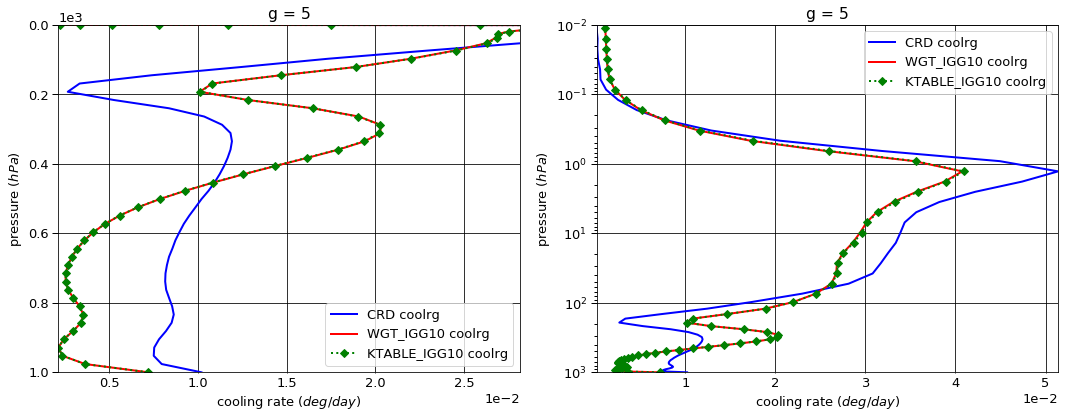

# Figure: cooling rate g-group 6

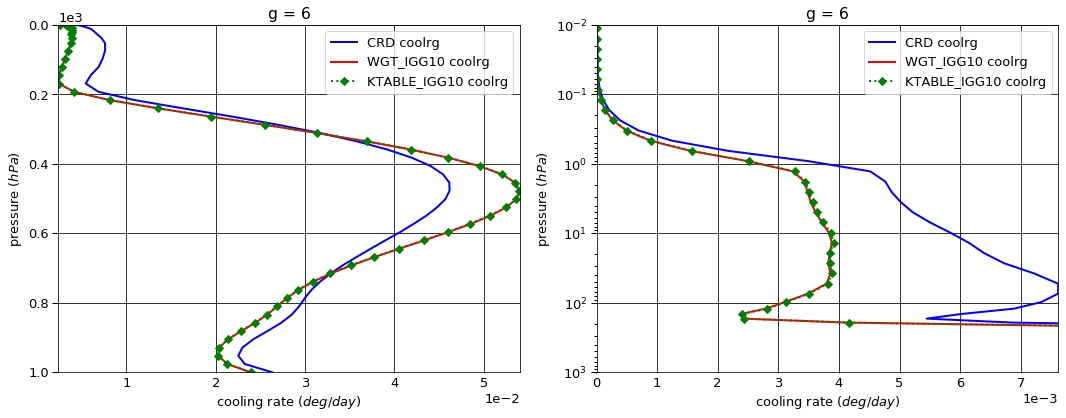

# Figure: cooling rate g-group 7

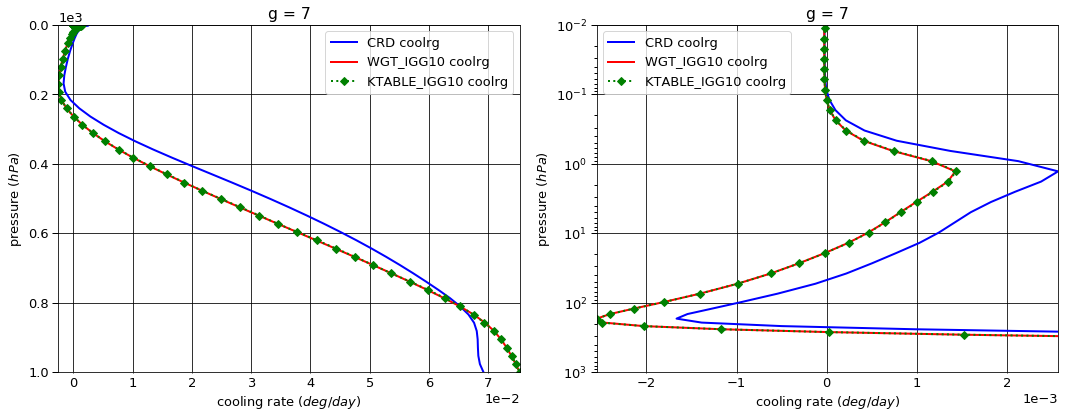

# Figure: cooling rate g-group 8

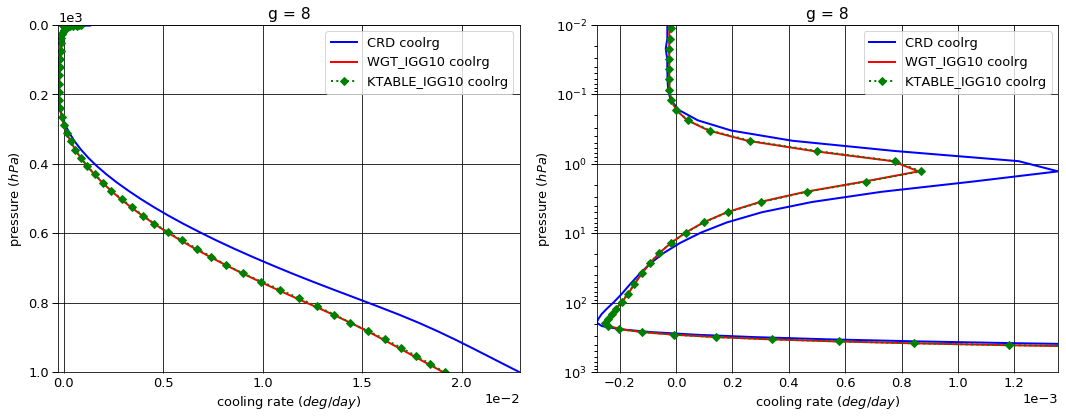

# Figure: cooling rate g-group 9

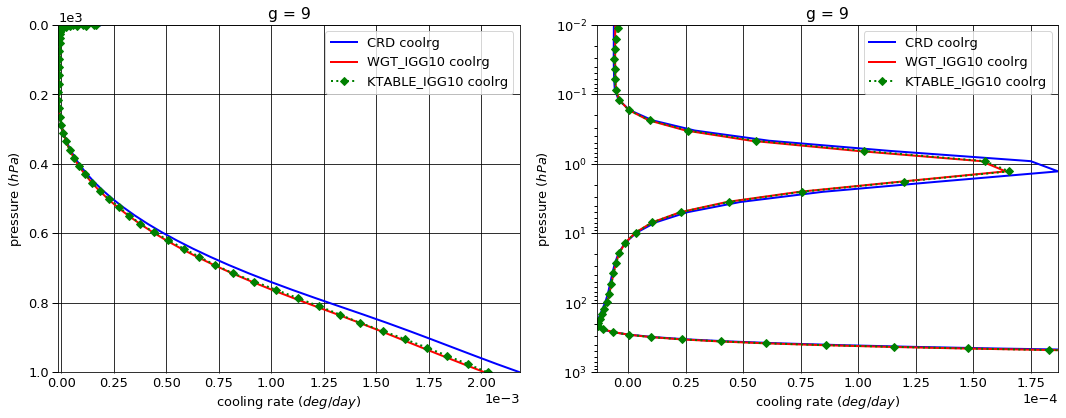

# Figure: cooling rate g-group total

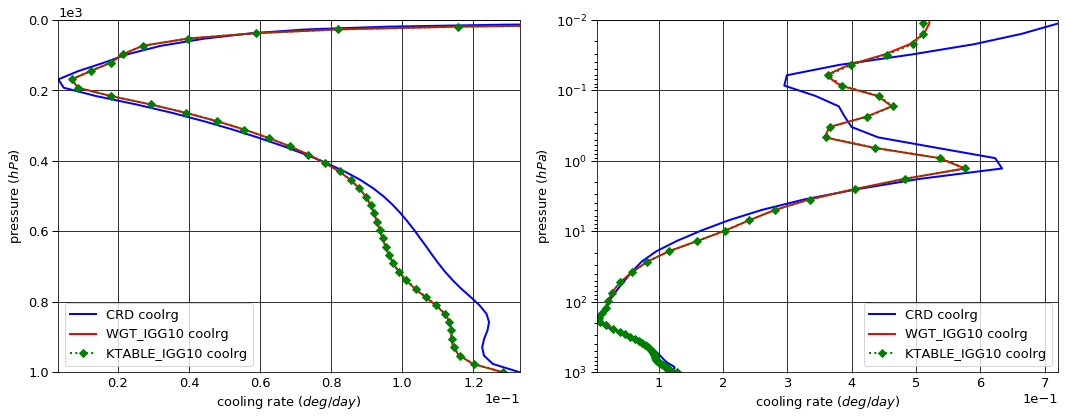

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                               
1 0.0      1      -0.020815  0.000000 -0.020815
  1013.0   76     -0.047427  0.047344 -0.000083
2 0.0      1      -0.044177  0.000000 -0.044177
  1013.0   76     -0.065535  0.064305 -0.001230
3 0.0      1      -0.234938  0.000000 -0.234938
  1013.0   76     -0.400215  0.372782 -0.027433
4 0.0      1      -0.338572  0.000000 -0.338572
  1013.0   76     -0.775169  0.762579 -0.012590
5 0.0      1      -1.630523  0.000000 -1.630523
  1013.0   76     -3.257783  2.936170 -0.321613
6 0.0      1      -3.663947  0.000000 -3.663947
  1013.0   76     -6.330641  5.997535 -0.333106
7 0.0      1      -7.857844  0.000000 -7.857844
  1013.0   76     -9.361437  5.461131 -3.900306
8 0.0      1      -9.907761  0.000000 -9.907761
  1013.0   76    -10.099769  1.040070 -9.059700
9 0.0      1      -5.884908  0.000000 -5.884908
  1013.0   76     -5.897432  0.083278 -5.814153


WGT_IGG10


flug      fldg     fnetg
g pressure level                               
1 0.0      1      -0.019590  0.000000 -0.019590
  1013.0   76     -0.047427  0.047394 -0.000033
2 0.0      1      -0.045169  0.000000 -0.045169
  1013.0   76     -0.065535  0.065399 -0.000136
3 0.0      1      -0.218432  0.000000 -0.218432
  1013.0   76     -0.400215  0.399537 -0.000678
4 0.0      1      -0.327271  0.000000 -0.327271
  1013.0   76     -0.775169  0.773977 -0.001192
5 0.0      1      -1.289601  0.000000 -1.289601
  1013.0   76     -3.257782  3.223554 -0.034228
6 0.0      1      -3.602917  0.000000 -3.602917
  1013.0   76     -6.330641  6.097603 -0.233038
7 0.0      1      -8.132922  0.000000 -8.132922
  1013.0   76     -9.361437  4.873088 -4.488348
8 0.0      1      -9.951973  0.000000 -9.951973
  1013.0   76    -10.099769  0.822458 -9.277311
9 0.0      1      -5.886006  0.000000 -5.886006
  1013.0   76     -5.897432  0.076249 -5.821183


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                               
1 0.0      1      -0.019602  0.000000 -0.019602
  1013.0   76     -0.047427  0.047394 -0.000033
2 0.0      1      -0.045168  0.000000 -0.045168
  1013.0   76     -0.065535  0.065399 -0.000136
3 0.0      1      -0.218522  0.000000 -0.218522
  1013.0   76     -0.400215  0.399537 -0.000678
4 0.0      1      -0.327389  0.000000 -0.327389
  1013.0   76     -0.775169  0.773977 -0.001192
5 0.0      1      -1.289242  0.000000 -1.289242
  1013.0   76     -3.257782  3.223549 -0.034233
6 0.0      1      -3.600286  0.000000 -3.600286
  1013.0   76     -6.330641  6.097861 -0.232780
7 0.0      1      -8.128684  0.000000 -8.128684
  1013.0   76     -9.361437  4.882424 -4.479012
8 0.0      1      -9.950377  0.000000 -9.950377
  1013.0   76    -10.099769  0.828892 -9.270877
9 0.0      1      -5.885822  0.000000 -5.885822
  1013.0   76     -5.897432  0.077213 -5.820219


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.225674e-03  0.000000  0.001226
  1013.0   76    -6.938894e-18  0.000049  0.000049
2 0.0      1     -9.917950e-04  0.000000 -0.000992
  1013.0   76     0.000000e+00  0.001094  0.001094
3 0.0      1      1.650517e-02  0.000000  0.016505
  1013.0   76     0.000000e+00  0.026755  0.026755
4 0.0      1      1.130046e-02  0.000000  0.011300
  1013.0   76     0.000000e+00  0.011398  0.011398
5 0.0      1      3.409213e-01  0.000000  0.340921
  1013.0   76     4.440892e-16  0.287384  0.287384
6 0.0      1      6.102980e-02  0.000000  0.061030
  1013.0   76     8.881784e-16  0.100069  0.100069
7 0.0      1     -2.750775e-01  0.000000 -0.275078
  1013.0   76     0.000000e+00 -0.588043 -0.588043
8 0.0      1     -4.421230e-02  0.000000 -0.044212
  1013.0   76     0.000000e+00 -0.217612 -0.217612
9 0.0      1     -1.098100e-03  0.000000 -0.001098
  1013.0   76     0.000000e+00 -0.007030 -0.007029


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.213921e-03  0.000000  0.001214
  1013.0   76    -6.938894e-18  0.000049  0.000049
2 0.0      1     -9.906550e-04  0.000000 -0.000991
  1013.0   76     0.000000e+00  0.001094  0.001094
3 0.0      1      1.641611e-02  0.000000  0.016416
  1013.0   76     0.000000e+00  0.026755  0.026755
4 0.0      1      1.118294e-02  0.000000  0.011183
  1013.0   76     0.000000e+00  0.011398  0.011398
5 0.0      1      3.412808e-01  0.000000  0.341281
  1013.0   76     4.440892e-16  0.287379  0.287379
6 0.0      1      6.366140e-02  0.000000  0.063661
  1013.0   76     8.881784e-16  0.100327  0.100327
7 0.0      1     -2.708403e-01  0.000000 -0.270840
  1013.0   76     0.000000e+00 -0.578706 -0.578706
8 0.0      1     -4.261560e-02  0.000000 -0.042616
  1013.0   76     0.000000e+00 -0.211178 -0.211178
9 0.0      1     -9.147000e-04  0.000000 -0.000915
  1013.0   76     0.000000e+00 -0.006066 -0.006066

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.753748
  1001.112500 75     0.000028
2 0.000312    1     -0.005349
  1001.112500 75     0.000107
3 0.000312    1     -0.000447
  1001.112500 75     0.000944
4 0.000312    1      0.000064
  1001.112500 75     0.001102
5 0.000312    1     -0.000543
  1001.112500 75     0.010203
6 0.000312    1      0.000006
  1001.112500 75     0.026325
7 0.000312    1     -0.000028
  1001.112500 75     0.069207
8 0.000312    1     -0.000029
  1001.112500 75     0.022932
9 0.000312    1     -0.000006
  1001.112500 75     0.002185


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.414600
  1001.112500 75     0.000012
2 0.000312    1     -0.006040
  1001.112500 75     0.000048
3 0.000312    1      0.001443
  1001.112500 75     0.000244
4 0.000312    1      0.000103
  1001.112500 75     0.000430
5 0.000312    1      0.000767
  1001.112500 75     0.007211
6 0.000312    1      0.000002
  1001.112500 75     0.023924
7 0.000312    1     -0.000028
  1001.112500 75     0.075333
8 0.000312    1     -0.000022
  1001.112500 75     0.019089
9 0.000312    1     -0.000005
  1001.112500 75     0.002017


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.753785e-01
  1001.112500 75     1.200919e-05
2 0.000312    1     -4.590720e-03
  1001.112500 75     4.845287e-05
3 0.000312    1      9.518334e-04
  1001.112500 75     2.435626e-04
4 0.000312    1     -3.387852e-06
  1001.112500 75     4.302994e-04
5 0.000312    1      5.233432e-04
  1001.112500 75     7.210522e-03
6 0.000312    1      6.459425e-07
  1001.112500 75     2.390134e-02
7 0.000312    1     -1.231791e-05
  1001.112500 75     7.530355e-02
8 0.000312    1     -4.409297e-06
  1001.112500 75     1.915656e-02
9 0.000312    1     -1.174505e-06
  1001.112500 75     2.031472e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.391485e-01
  1001.112500 75    -1.564365e-05
2 0.000312    1     -6.913478e-04
  1001.112500 75    -5.837634e-05
3 0.000312    1      1.890256e-03
  1001.112500 75    -7.003161e-04
4 0.000312    1      3.892927e-05
  1001.112500 75    -6.721142e-04
5 0.000312    1      1.310084e-03
  1001.112500 75    -2.992271e-03
6 0.000312    1     -4.175354e-06
  1001.112500 75    -2.400554e-03
7 0.000312    1      5.669170e-07
  1001.112500 75     6.125505e-03
8 0.000312    1      6.942897e-06
  1001.112500 75    -3.843416e-03
9 0.000312    1      5.798377e-07
  1001.112500 75    -1.675127e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.378370
  1001.112500 75    -0.000016
2 0.000312    1      0.000758
  1001.112500 75    -0.000058
3 0.000312    1      0.001399
  1001.112500 75    -0.000700
4 0.000312    1     -0.000068
  1001.112500 75    -0.000672
5 0.000312    1      0.001066
  1001.112500 75    -0.002993
6 0.000312    1     -0.000005
  1001.112500 75    -0.002423
7 0.000312    1      0.000016
  1001.112500 75     0.006097
8 0.000312    1      0.000024
  1001.112500 75    -0.003775
9 0.000312    1      0.000005
  1001.112500 75    -0.000153

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.583485,0.000000,-29.583485
1013.0,76,-36.235408,16.765195,-19.470214



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.473882,0.000000,-29.473882
1013.0,76,-36.235408,16.379259,-19.856149



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.465091,0.000000,-29.465091
1013.0,76,-36.235408,16.396247,-19.839161



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.109603,0.000000,0.109603
1013.0,76,0.000000,-0.385936,-0.385936



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.118394,0.000000,0.118394
1013.0,76,0.000000,-0.368948,-0.368948


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.747417
1001.112500,75,0.133033



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.410821
1001.112500,75,0.128308



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.372242
1001.112500,75,0.128338



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.336597
1001.112500,75,-0.004725



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.375175
1001.112500,75,-0.004695


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001313,0.001276
2,0.001813,0.001769
3,0.011062,0.010838
4,0.021438,0.020926
5,0.090000,0.088449
6,0.174937,0.171284
7,0.258125,0.257021
8,0.278438,0.282004
9,0.162875,0.166433


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.758133e-19
2,1.296272e-20
3,9.557418e-22
4,6.761756e-22
5,5.021768e-23
6,1.772266e-22
7,1.332107e-23
8,1.001266e-24
9,1.011442e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.758133e-19,NaN,0.001313,0.001276,0.001313,0.001276,1.0
2,1.296272e-20,0.073730,0.001813,0.001769,0.003125,0.003045,1.0
3,9.557418e-22,0.073730,0.011062,0.010838,0.014187,0.013883,1.0
4,6.761756e-22,0.707488,0.021438,0.020926,0.035625,0.034809,10.0
5,5.021768e-23,0.074267,0.090000,0.088449,0.125625,0.123258,10.0
6,1.772266e-22,3.529167,0.174937,0.171284,0.300562,0.294542,500.0
7,1.332107e-23,0.075164,0.258125,0.257021,0.558688,0.551563,500.0
8,1.001266e-24,0.075164,0.278438,0.282004,0.837125,0.833567,500.0
9,1.011442e-25,0.101016,0.162875,0.166433,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.312490e-19  2.785435e-19   1.907239  2.410848e-03
      2 0.000312     9.321840e-21  7.123461e-21   1.308611  4.119901e-05
      3 0.000312     7.853566e-22  3.994280e-22   1.966203  3.544397e-06
      4 0.000312     6.725807e-24  5.991006e-24   1.122651  3.443602e-08
      5 0.000312     1.268736e-23  4.735817e-24   2.679023  5.032375e-08
      6 0.000312     1.213591e-25  1.183009e-25   1.025851  6.326985e-10
      7 0.000312     1.147266e-25  9.194986e-26   1.247708  5.470187e-10
      8 0.000312     6.224216e-26  1.975792e-26   3.150239  2.844997e-10
      9 0.000312     1.995327e-26  3.010619e-27   6.627631  1.011379e-10
2     1 0.000750     5.337453e-19  2.796009e-19   1.908954  9.754595e-04
      2 0.000750     9.387265e-21  7.167488e-21   1.309701  1.670197e-05
      3 0.000750     7.916702e-22  4.018869e-22   1.969883  1.438632e-06
      4 0.000750     6.843951e-24  6.099996e-24   1.121960  1.411642e-08
      5 0.000750     1.278318e-23  4.764251e-24   2.683146  2.041657e-08
      6 0.000750     1.227491e-25  1.196526e-25   1.025879  2.577573e-10
      7 0.000750     1.159736e-25  9.282471e-26   1.249383  2.225939e-10
      8 0.000750     6.306865e-26  1.990123e-26   3.169083  1.160635e-10
      9 0.000750     2.020440e-26  3.029101e-27   6.670098  4.124766e-11
3     1 0.001052     5.390997e-19  2.818464e-19   1.912743  1.381192e-03
      2 0.001052     9.524598e-21  7.257407e-21   1.312397  2.373400e-05
      3 0.001052     8.048210e-22  4.065011e-22   1.979874  2.049181e-06
      4 0.001052     7.018950e-24  6.255158e-24   1.122106  2.030213e-08
      5 0.001052     1.298479e-23  4.820000e-24   2.693940  2.906027e-08
      6 0.001052     1.252791e-25  1.220992e-25   1.026043  3.688905e-10
      7 0.001052     1.185692e-25  9.460811e-26   1.253267  3.187093e-10
      8 0.001052     6.484786e-26  2.019712e-26   3.210748  1.671988e-10
      9 0.001052     2.074783e-26  3.067873e-27   6.762937  5.939457e-11
4     1 0.001476     5.447995e-19  2.842372e-19   1.916707  1.957408e-03
      2 0.001476     9.672409e-21  7.354064e-21   1.315247  3.376607e-05
      3 0.001476     8.190297e-22  4.115206e-22   1.990252  2.922818e-06
      4 0.001476     7.221624e-24  6.436216e-24   1.122029  2.930466e-08
      5 0.001476     1.320262e-23  4.880285e-24   2.705296  4.141781e-08
      6 0.001476     1.280970e-25  1.248264e-25   1.026201  5.291057e-10
      7 0.001476     1.213946e-25  9.654339e-26   1.257410  4.570997e-10
      8 0.001476     6.678626e-26  2.051620e-26   3.255294  2.413344e-10
      9 0.001476     2.133840e-26  3.109449e-27   6.862438  8.568634e-11
5     1 0.002070     5.505334e-19  2.866449e-19   1.920611  2.773300e-03
      2 0.002070     9.823182e-21  7.452767e-21   1.318058  4.803248e-05
      3 0.002070     8.335935e-22  4.167535e-22   2.000207  4.168723e-06
      4 0.002070     7.451182e-24  6.643492e-24   1.121576  4.241361e-08
      5 0.002070     1.342571e-23  4.942473e-24   2.716396  5.902599e-08
      6 0.002070     1.311141e-25  1.277500e-25   1.026333  7.595375e-10
      7 0.002070     1.243145e-25  9.854039e-26   1.261559  6.555863e-10
      8 0.002070     6.878564e-26  2.084297e-26   3.300184  3.482878e-10
      9 0.002070     2.194563e-26  3.151701e-27   6.963107  1.235890e-10
6     1 0.002904     5.562924e-19  2.890681e-19   1.924433  3.929482e-03
      2 0.002904     9.977153e-21  7.553937e-21   1.320788  6.834266e-05
      3 0.002904     8.485517e-22  4.222756e-22   2.009473  5.947713e-06
      4 0.002904     7.717369e-24  6.886731e-24   1.120614  6.163521e-08
      5 0.002904     1.365449e-23  5.007130e-24   2.727010  8.414432e-08
      6 0.002904     1.343874e-25  1.309271e-25   1.026429  1.091971e-09
      7 0.002904     1.273400e-25  1.006102e-25   1.265677  9.406417e-10
      8 0.002904     7.084726e-26  2.117874e-26   3.345207  5.027224e-10
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
